### Accuracy Impacts of Using Augmented Data During Validation 

This notebook provides a close-up examination of the impact using augmented data during the validation phase of an epoch has on model performance.  

...

While the team's focus is on shrinking the distribution gap observed between the CIFAR 10 and 10.1 testsets, the results are examined from two dimensions:
  1. What, if any, effect is observed on the distribution gap when comparing model evaluations on an augemented CIFAR 10 testset to an augmented CIFAR 10.1 tesetset.
  2. What, if any, effect is observed in general model accuracy?
  
 

#### Install Libraries and Packages

In [1]:
import os
import re
import pandas as pd
from glob import glob
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 500)

#### Load the Data

In [2]:
search_path = "../model_results"
file_extension = "*.csv"

# Retrieve results from github directory
dfs = []
[dfs.append(pd.read_csv(file, index_col=0))
 for path, subdir, files in os.walk(search_path)
 for file in glob(os.path.join(path, file_extension))]

# Convert the accuracy scores to percentages.
df = pd.concat(dfs, ignore_index=True)
df['Accuracy'] = df['Accuracy'].apply(lambda x: x*100)

# Filter the results to focus on densenet, the model the experiment was run on.
df_dnet = df[df["Model"].str.contains('densenet')]

# Get accuracy score of last epoch for each model type
df_dnet = df_dnet[df_dnet.groupby(['Model'])['Epoch'].transform(max) == df_dnet['Epoch']]

# Filter columns to those we need for analysis
df_dnet = df_dnet[['Model', 'Accuracy', 'Loss', 'Testset']].sort_values(by=['Model'])#

df_dnet['ra'] = df_dnet['Model'].str.contains("ra_")
df_dnet['val'] = df_dnet['Model'].str.contains("_c10val")
df_dnet['refined'] = df_dnet['Model'].str.contains("refined400")

def ra_N_extraction(row):
    p3 = re.compile("ra_(\d+)_(\d+)")
    N=0 
    if row['ra'] == True :
        srch3 = p3.search(row['Model'].lower())
        N = int(srch3.group(1))
    return N

def ra_M_extraction(row):
    p3 = re.compile("ra_(\d+)_(\d+)")
    M=0 
    if row['ra'] == True :
        srch3 = p3.search(row['Model'].lower())
        M = int(srch3.group(2))
    return M

def chart_name(row):
    newname = ""
    if row['ra'] == False:
        newname = "Original Model"
    else:
        if row['refined'] == True :
            newname += "Train: RA N=" + str(row['N']) + ",M=" + str(row['M'])
        else:
            newname += "Train: RA N=" + str(row['N']) + ",M=" + str(row['M']) + " + Unaugmented Refine"

        if row['val'] == True:
            newname += "; Val: Unaugmented"
        else:
            newname += "; Val: Augmented"        
    return newname
    
df_dnet['N'] = df_dnet.apply(lambda row: ra_N_extraction(row), axis=1)
df_dnet['M'] = df_dnet.apply(lambda row: ra_M_extraction(row), axis=1)
df_dnet['ChartName'] = df_dnet.apply(lambda row: chart_name(row), axis=1)
cols = ['N', 'M']
df_dnet['hue'] = df_dnet[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

#### Results Analysis

In [3]:
df_dnet2 = df_dnet[df_dnet['ra']==True]
df_dnet2 = df_dnet2[["val", "ra", "refined", "N", "M", "Accuracy", "Testset"]]

s = df_dnet2.groupby(['ra', 'N', 'M', "refined", "Testset"]).cumcount()

df1 = df_dnet2.set_index(['ra', 'N', 'M', "refined", "Testset", s]).unstack().sort_index(level=1, axis=1)
df1.columns = [f'{x}{y}' for x, y in df1.columns]
df1 = df1.rename(columns={"Accuracy0": "Accuracy_Augmented_Val", "Accuracy1": "Accuracy_Unaugmented_Val"})
df1.drop(columns=['val0', 'val1'], inplace=True)
df1["Delta_Accuracy"] = (df1["Accuracy_Augmented_Val"] - df1["Accuracy_Unaugmented_Val"]).abs()
df1["Unaugmented_HigherAcc"] =  df1["Accuracy_Augmented_Val"] < df1["Accuracy_Unaugmented_Val"]
df2 = df1.reset_index()
df1

Accuracy_Augmented_Val  Accuracy_Unaugmented_Val  \
ra   N M  refined Testset                                                       
True 2 5  False   cifar10                     89.52                     89.07   
                  cifar10.1                   77.10                     77.70   
          True    cifar10                     93.13                     93.21   
                  cifar10.1                   84.70                     85.70   
       20 False   cifar10                     79.00                     81.54   
                  cifar10.1                   63.90                     68.15   
          True    cifar10                     91.68                     91.23   
                  cifar10.1                   82.90                     83.15   
     3 20 False   cifar10                     71.15                     67.69   
                  cifar10.1                   57.95                     54.80   
          True    cifar10                     90.76                     90.24   
                  cifar10.1                   80.95                     81.35   

                             Accuracy2  val2  Delta_Accuracy  \
ra   N M  refined Testset                                      
True 2 5  False   cifar10          NaN   NaN            0.45   
                  cifar10.1        NaN   NaN            0.60   
          True    cifar10          NaN   NaN            0.08   
                  cifar10.1        NaN   NaN            1.00   
       20 False   cifar10        81.54  True            2.54   
                  cifar10.1      68.15  True            4.25   
          True    cifar10        91.23  True            0.45   
                  cifar10.1      83.15  True            0.25   
     3 20 False   cifar10          NaN   NaN            3.46   
                  cifar10.1        NaN   NaN            3.15   
          True    cifar10          NaN   NaN            0.52   
                  cifar10.1        NaN   NaN            0.40   

                             Unaugmented_HigherAcc  
ra   N M  refined Testset                           
True 2 5  False   cifar10                    False  
                  cifar10.1                   True  
          True    cifar10                     True  
                  cifar10.1                   True  
       20 False   cifar10                     True  
                  cifar10.1                   True  
          True    cifar10                    False  
                  cifar10.1                   True  
     3 20 False   cifar10                    False  
                  cifar10.1                  False  
          True    cifar10                    False  
                  cifar10.1                   True

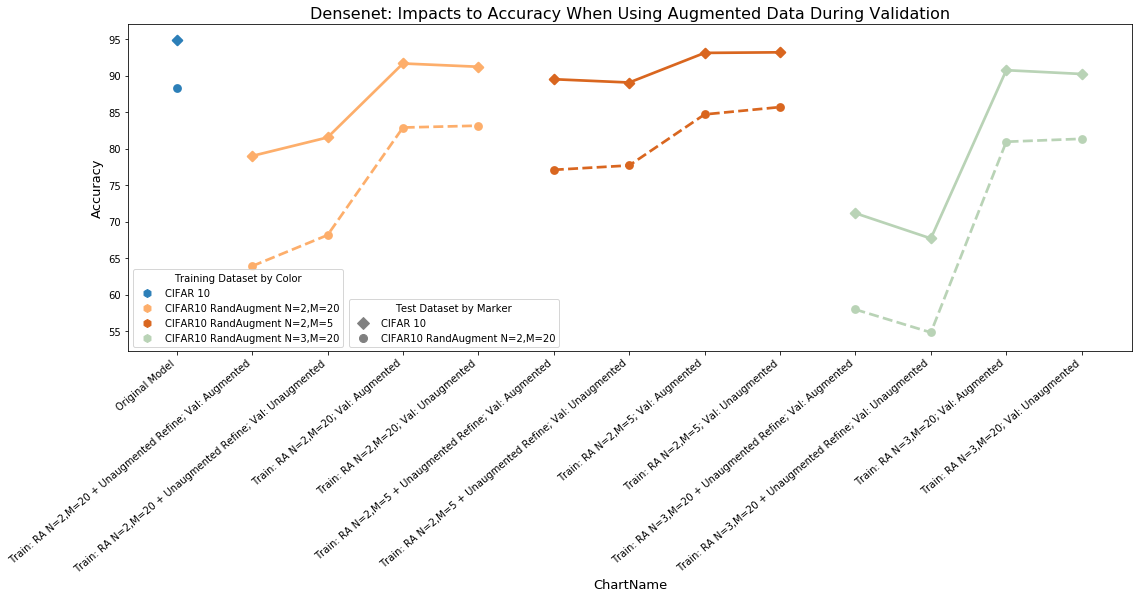

In [115]:
flatui = ["#2c7fb8", "#fdae6b", "#D9661F", "#B9D3B6", "#B9D3B6", "#859438"]

f, ax = plt.subplots(figsize=(18, 6))
sp = sns.pointplot(x="ChartName", hue="hue", y="Accuracy", data=df_dnet[df_dnet['Testset'] == 'cifar10'], 
                   markers=['D'] * 4, linestyles=['-']*4, palette=flatui, ci=None)  
plt.xlabel('Validation Data Type', fontsize=13)
plt.ylabel('Accuracy', fontsize=13)
plt.title('Densenet: Impacts to Accuracy When Using Augmented Data During Validation', fontsize=16)
plt.setp(ax.get_xticklabels(), rotation=40, horizontalalignment='right')
sns.set_style()

sp = sns.pointplot(x="ChartName", hue="hue", y="Accuracy", data=df_dnet[df_dnet['Testset'] == 'cifar10.1'], 
                   markers=['o']*4, linestyles=['--']*4, palette=flatui, ci=None,alpha=0.7) # and slightly transparent

train_datasets = ['CIFAR 10', 'CIFAR10 RandAugment N=2,M=20', 'CIFAR10 RandAugment N=2,M=5', 'CIFAR10 RandAugment N=3,M=20']
test_datasets = ['CIFAR 10', 'CIFAR 10.1']

h = [plt.plot([],[], color=c, marker="h", ms=8, ls="")[0] for i,c in zip(train_datasets, flatui)]
leg = ax.legend(handles=h, labels=train_datasets,loc=(.005,.01), title="Training Dataset by Color")
ax.add_artist(leg)

h2 = [plt.plot([],[], color='grey', marker=m, ms=8, ls="")[0] for i,m in zip(test_datasets, ['D', 'o'])]
ax.legend(handles=h2, labels=train_datasets,loc=(.22,0.01), title="Test Dataset by Marker")

pass

In [233]:
df_val_cifar10 = df2[df2.Testset == 'cifar10'][['Unaugmented_HigherAcc']].apply(pd.value_counts)
df_val_cifar101 = df2[df2.Testset == 'cifar10.1'][['Unaugmented_HigherAcc']].apply(pd.value_counts)
df_val_cifar101.sort_index(inplace=True)
df_val_cifar10.sort_index(inplace=True)
outcomes = df_val_cifar10.join(df_val_cifar101, lsuffix="CIFAR10", rsuffix="CIFAR10.1")
outcomes.columns = outcomes.columns.str.lstrip("Unaugmented_HigherAcc")

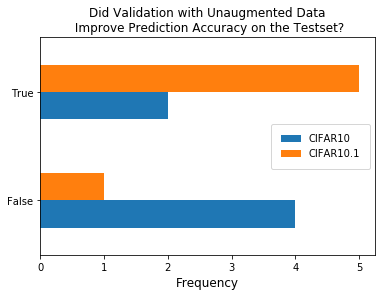

In [234]:
outcomes.plot.barh()
plt.legend(fancybox=True, loc='center right', borderpad=1)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('', fontsize=11)
plt.title('Did Validation with Unaugmented Data\n Improve Prediction Accuracy on the Testset?')
pass

Observations:
  - Accuracy on CIFAR 10.1 more generally improved when validation occurred with unaugmented data
  - Refining on unaugmented data reduces the performance delta observed.
  